<a href="https://colab.research.google.com/github/TAKE-JP-17/Pytorch/blob/main/1D_Derivative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 500/5000, Loss: 0.000069
Epoch 1000/5000, Loss: 0.000017
Epoch 1500/5000, Loss: 0.000004
Epoch 2000/5000, Loss: 0.000002
Epoch 2500/5000, Loss: 0.000002
Epoch 3000/5000, Loss: 0.000006
Epoch 3500/5000, Loss: 0.000001
Epoch 4000/5000, Loss: 0.000172
Epoch 4500/5000, Loss: 0.000001
Epoch 5000/5000, Loss: 0.000001


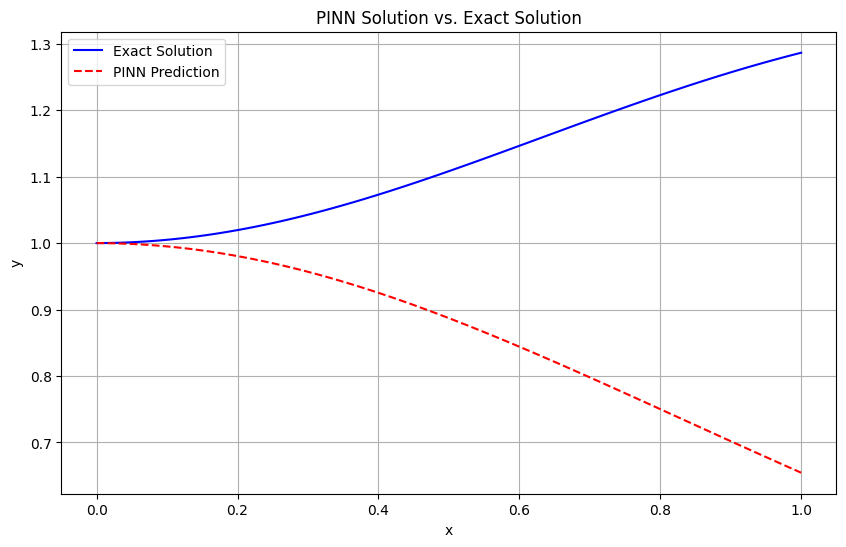

Mean Absolute Error (MAE): 0.253805


In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Define the physics-informed neural network (PINN)
class PINN(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=50, output_dim=1, num_hidden_layers=3):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_dim, hidden_dim))
        self.layers.append(nn.Tanh())
        for _ in range(num_hidden_layers):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


# Define the exact solution for comparison
def exact_solution(x):
    C = 1  # The constant for y(0) = 1
    integrand = lambda t: np.exp(t**2) * np.sin(t)
    integral, _ = quad(integrand, 0, x)
    return np.exp(-x**2) * integral + C


# Define the loss function
def compute_loss(model, x_physics, x_boundary, y_boundary):
    # Physics loss
    x_physics.requires_grad = True
    y_physics = model(x_physics)
    dy_dx = torch.autograd.grad(y_physics, x_physics, torch.ones_like(y_physics), create_graph=True)[0]
    p = 2 * x_physics
    q = torch.sin(x_physics)
    physics_residual = dy_dx + p * y_physics - q
    physics_loss = torch.mean(physics_residual**2)

    # Boundary loss
    y_boundary_pred = model(x_boundary)
    boundary_loss = torch.mean((y_boundary_pred - y_boundary)**2)

    # Total loss
    return physics_loss + boundary_loss


# Training parameters
epochs = 5000
learning_rate = 0.001
x_physics = torch.linspace(0, 1, 100).view(-1, 1).float()
x_boundary = torch.tensor([[0.0]]).float()
y_boundary = torch.tensor([[1.0]]).float()

# Model, optimizer, and training
model = PINN()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    loss = compute_loss(model, x_physics, x_boundary, y_boundary)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.6f}")

# Plot results
x_test = torch.linspace(0, 1, 100).view(-1, 1).float()
y_pred = model(x_test).detach().numpy()
x_test_np = x_test.numpy().flatten()
y_exact = np.array([exact_solution(x) for x in x_test_np])

plt.figure(figsize=(10, 6))
plt.plot(x_test_np, y_exact, label="Exact Solution", color="blue")
plt.plot(x_test_np, y_pred, label="PINN Prediction", color="red", linestyle="--")
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN Solution vs. Exact Solution")
plt.legend()
plt.grid()
plt.show()

# Error analysis
mae = np.mean(np.abs(y_pred.flatten() - y_exact))
print(f"Mean Absolute Error (MAE): {mae:.6f}")
